# Анализ продаж видеоигр

**Цель исследования:**
- Выявить определяющие успешность игры закономерности, для того чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании

**Входные данные из открытых источников**
- Исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы 

**Описание данных:**
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## 1. Обзор данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from scipy import stats as st
import seaborn as sns

In [3]:
df = pd.read_csv('/Users/yusuf/Desktop/Programming/Projects/Data/games.csv')

In [4]:
pd.set_option('display.max_columns', 50)
pd.set_option('max_colwidth', 400)
sns.set(rc={'figure.figsize':(16, 7)})

In [5]:
display(df.head(10))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Пропуски:** пара пропусков в названии игры - их можно удалить, потому что без названия они бесполезны; Пропуски по рейтингам нужно попробовать заполнить маркерами, средние здесь подбирать будет некорректно. Их слишком много, по ним резать данные не стоит. 

**Данные:** год выхода игры нужно привести к формат целого, так как с датой будет 1 января, а игра могла выйти в любой другой день в году. Аббривеатура tbd в рейтинге означает то, что рейтинг игре еще не присужден 

## 2. Предобработка данных

Приведу названия столбцов к нижему регистру, также и некоторые столбцы (учитывая человеческий фактор, могли быть ошибки), закрою пропуски и заменю тип данных

In [7]:
df.columns = map(str.lower, df.columns)
df['name'] = df['name'].str.lower()
df['platform'] = df['platform'].str.lower()
df['genre'] = df['genre'].str.lower()
df['rating'] = df['rating'].str.lower()
df = df.dropna(subset = ['name'])

Меняю пропуски и значение tbd для того, чтобы в будущем было проще считать корреляцию

In [8]:
df['critic_score'] = df['critic_score'].fillna(-77)
df['user_score'] = df['user_score'].fillna(-77)
df['rating'] = df['rating'].fillna(-77)
df['user_score'] = df['user_score'].replace("tbd", -10)

Приведу оценки пользователей к 100-балльной шкале для того, чтобы их было проще сравнивать с оценками критиков

In [9]:
df['user_score'] = df['user_score'].astype(float)

def score(number):
    if (number <= 10) and (number >= 0):
        number = number * 10
    return number
 
df['user_score'] = df['user_score'].apply(score)

In [10]:
df['rating'].value_counts()

-77     6764
e       3990
t       2961
m       1563
e10+    1420
ec         8
k-a        3
rp         3
ao         1
Name: rating, dtype: int64

In [11]:
df['rating'] = df['rating'].replace("ec", "e") #early childhood часто имеет рейтинг everyone
df['rating'] = df['rating'].replace("rp", -77) #rating pending
df['rating'] = df['rating'].replace("k-a", "e") #kids to adults или everyone
df['rating'] = df['rating'].replace("ao", "m") #adults only или mature

In [12]:
df = df.dropna(subset = ['year_of_release']) #удалю пропуски для того, чтобы привести данные к нужному виду, их количество незначительное
df['year_of_release'] = df['year_of_release'].astype(int)
df['critic_score'] = df['critic_score'].astype(int)
df['user_score'] = df['user_score'].astype(int)
display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76,80,e
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,-77,-77,-77
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82,83,e
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80,80,e
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,-77,-77,-77


Теперь добавлю столбец с суммарными продажами по всем регионам

In [13]:
df['sales_sum'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
display(df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76,80,e,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,-77,-77,-77,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82,83,e,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80,80,e,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,-77,-77,-77,31.38


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       16444 non-null  int64  
 10  rating           16444 non-null  object 
 11  sales_sum        16444 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.6+ MB


Пропусков не осталось

## 3. Анализ данных

### 3.1 Посмотрим сколько игр выпускалась по годам

In [15]:
def decade(row):
    year = row['year_of_release']
    if year <= 1989:
        return '80-e'
    if year <= 1999:
        return '90-e'
    if year <= 2009:
        return '00-e'
    if year <= 2019:
        return '10-e'
    
df['decade'] = df.apply(decade, axis = 1)

In [16]:
df['decade'].value_counts()

00-e    9193
10-e    5277
90-e    1769
80-e     205
Name: decade, dtype: int64

Больше всего игр было выпущено в промежуток с 2000 по 2010 года. В 2 раза меньше игр было выпущено в следующую декаду, но она ограничена 2016 годом, возможно к концу десятилетия с таким трендом перегнала. Хотя, из-за возросшей стоимости разработки, эта цифра могла не сильно вырасти. В восьмидесятые выпущено игр по количеству ровняющихся примерно 2% выпущенных игр нулевых

Посмотрю на линейный график по годам

Text(0, 0.5, 'Количество проданных игр, млн')

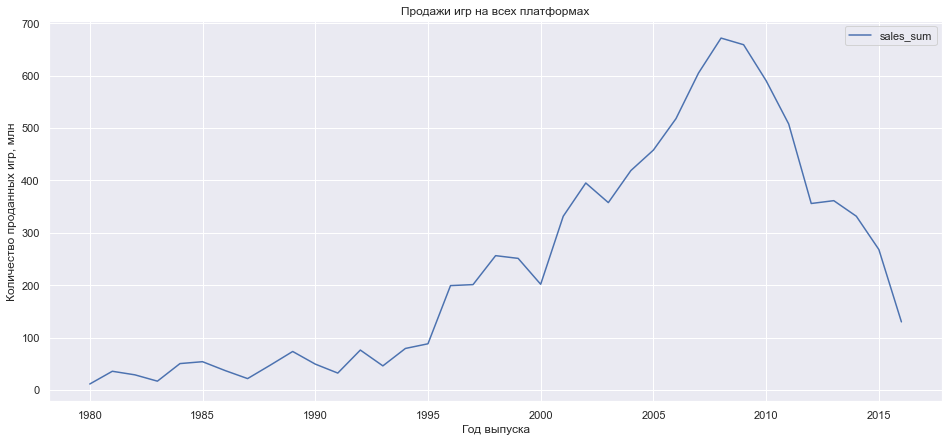

In [17]:
df.pivot_table(index='year_of_release',values='sales_sum',aggfunc='sum').plot(grid=True)
plt.title('Продажи игр на всех платформах')
plt.xlabel('Год выпуска')
plt.ylabel('Количество проданных игр, млн')

Продажи игр были примерное на одном уровне на протяжении 15 лет с 1980 по 1995 года, после чего начался бум, продлившийся до 2008 года и последующий после него спад - который мог произойти по причине мирового кризиса

### 3.2 Посмотрим на продажи по платформам

Сразу посмотрим на самые продаваемые консоли в истории

In [18]:
df.pivot_table(index = 'platform', values = 'sales_sum', aggfunc = 'sum').sort_values(by = 'sales_sum', ascending = False)

,sales_sum
platform,
ps2,1233.56
x360,961.24
ps3,931.34
wii,891.18
ds,802.78
ps,727.58
ps4,314.14
gba,312.88
psp,289.53


Больше всего проданных копий игр на PS2, что логично, так как это самая продаваемая игровая консоль в истории. Теперь посмотрим на продажи топовых платформ по годам, продажи резко падают начиная с PS4, с него и отсечем

In [19]:
platform_filtered = ['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps'] # создаю список с топовыми платформами по продажам
 
df_top = df.query('platform in @platform_filtered and year_of_release >= 1990').pivot_table(index='year_of_release',columns='platform',values='sales_sum',aggfunc='sum')

Text(0, 0.5, 'Количество проданных игр, млн')

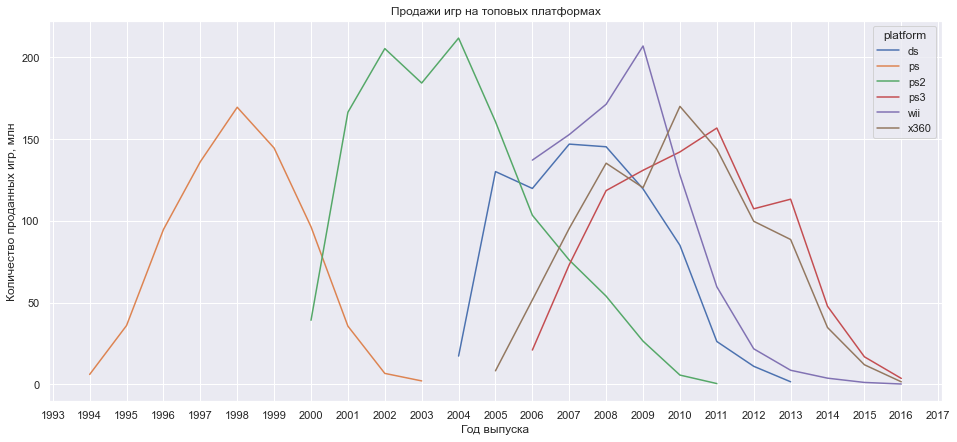

In [20]:
df_top.plot(grid=True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Продажи игр на топовых платформах')
plt.xlabel('Год выпуска')
plt.ylabel('Количество проданных игр, млн')

Судя по графику, срок жизни платформы - около 7-10 лет. За это время консоль успевает набрать пик популярности и уйти на покой. Посчитаю точно, посмотрим какое значение получим

In [21]:
life_cycle = df.query('platform in ["ps","ps2","ds"] and year_of_release >= 1990').pivot_table(index = 'platform', values = 'year_of_release', aggfunc = ['max', 'min'])
display(life_cycle)

,max,min
,year_of_release,year_of_release
platform,,
ds,2013,2004
ps,2003,1994
ps2,2011,2000


Средняя продолжительность жизни отживших своё консолей равняется 10 годам

### 3.3 Посмотрим на те же данные, но за актуальный период времени

Для дальнейшего анализа я возьму данные за период с 2013 года, так как прогнозировать надо на 2017 и дальше, плюс в 2013 происходит закат консолей старого поколения. 

In [22]:
df_new = df.query('year_of_release >= 2013')

In [23]:
df_new.pivot_table(index = 'platform', values = 'sales_sum', aggfunc = 'sum').sort_values(by = 'sales_sum', ascending = False)

,sales_sum
platform,
ps4,314.14
ps3,181.43
xone,159.32
3ds,143.25
x360,136.80
wiiu,64.63
pc,39.43
psv,32.99
wii,13.66


По новым данным заметно, что консоли нового поколения (PS4, XBOXone, 3DS и WiiU) вырываются в лидеры, тогда как продажи "старых" консолей начинают падать

Далее визуально проанализирую продажи игр по консолям с помощью "ящика с усами"

Text(0, 0.5, 'Количество проданных игр, млн')

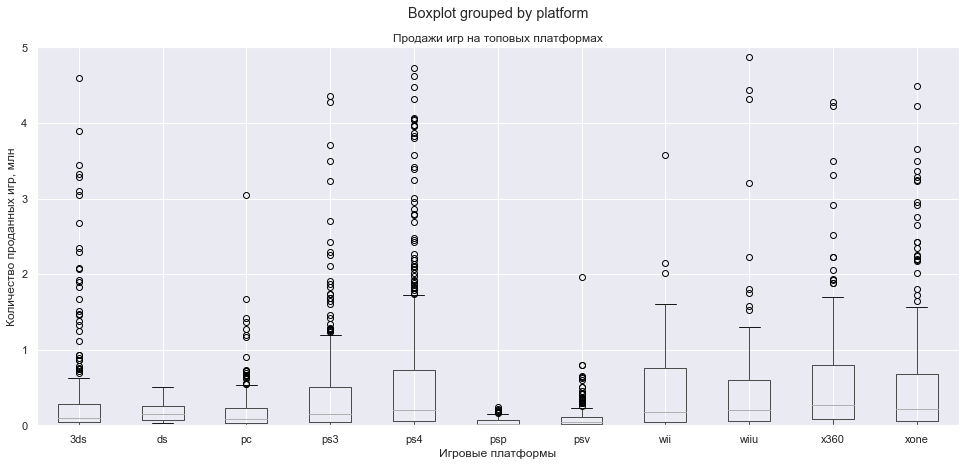

In [24]:
df_new.boxplot('sales_sum', by='platform').set_ylim(0, 5)
plt.title('Продажи игр на топовых платформах')
plt.xlabel('Игровые платформы')
plt.ylabel('Количество проданных игр, млн')

Результаты в пределах усов говорят о массе игр, продающихся на консолях. А выбросы говорят о блокбастерах, продающихся огромными тиражами. Их довольно много на PS4, так как это консоль с эксклюзивным контентом. Заметно, что PSP и PSVita - нишевые консоли, доживающие свое время, как и DS. Платформы Nintendo - Wii и WiiU практически не притягивают блокбастеры, при этом их же консоль 3DS имеет их в огромном количестве

### 3.4 Посмотрю на корреляцию между отзывами и продажами для самой перспективной консоли

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


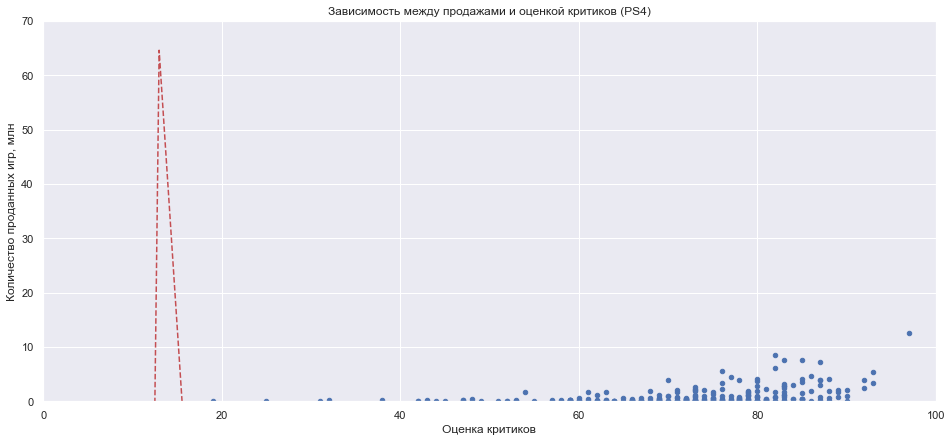

In [25]:
sorted_sum_df = df_new.sort_values('sales_sum')
sorted_sum_df.query('(platform == "ps4") & (critic_score > 0)').plot(x='critic_score', y='sales_sum', kind='scatter', title='Зависимость между продажами и оценкой критиков (PS4)', xlim=(0,100), ylim=(0, 70), grid=True)

z = np.polyfit(sorted_sum_df['sales_sum'], sorted_sum_df['critic_score'], 2)
p = np.poly1d(z)
plt.plot(sorted_sum_df['critic_score'].sort_values(), p(sorted_sum_df['critic_score'].sort_values()) ,"r--")
plt.xlabel('Оценка критиков')
plt.ylabel('Количество проданных игр, млн')
plt.show()

Большинство игр продались ограниченным тиражем, что логично. При этом заметно, что блокбастеры с огромными продажами получали высший балл. Начиная с оценки в 25 баллов, продажи игр начинали расти пропорционально 


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Количество проданных игр, млн')

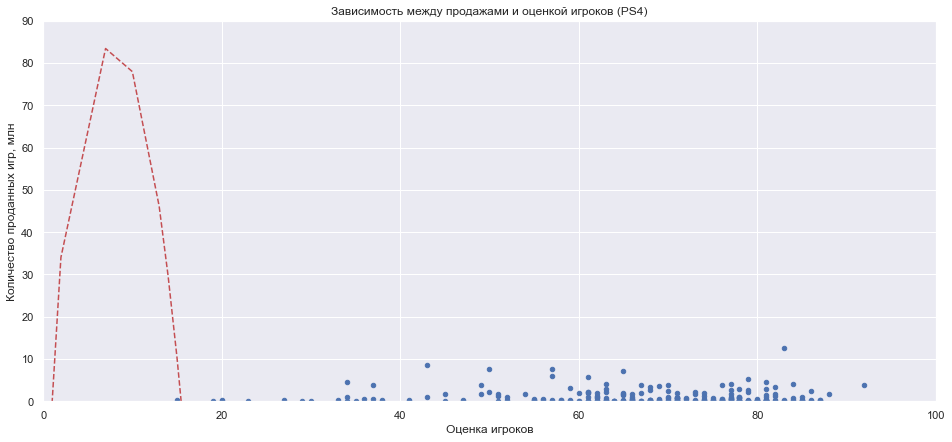

In [26]:
sorted_sum_df.query('(platform == "ps4") & (user_score != -77) & (user_score != -10)').plot(x='user_score', y='sales_sum', kind='scatter', title='Зависимость между продажами и оценкой игроков (PS4)', xlim=(0,100), ylim=(0, 90), grid=True)

z = np.polyfit(sorted_sum_df['sales_sum'], sorted_sum_df['user_score'], 2)
p = np.poly1d(z)
plt.plot(sorted_sum_df['user_score'].sort_values(), p(sorted_sum_df['user_score'].sort_values()) ,"r--")
plt.xlabel('Оценка игроков')
plt.ylabel('Количество проданных игр, млн')

Лучше всего игры на данной консоли продаются в среднем рейтинге (4-5.5), а также на самом высоком рейтинге. Какой-то закономерности явной не наблюдается, видимо игры здесь покупают не из-за оценок игроков

Text(0, 0.5, 'Количество проданных игр, млн')

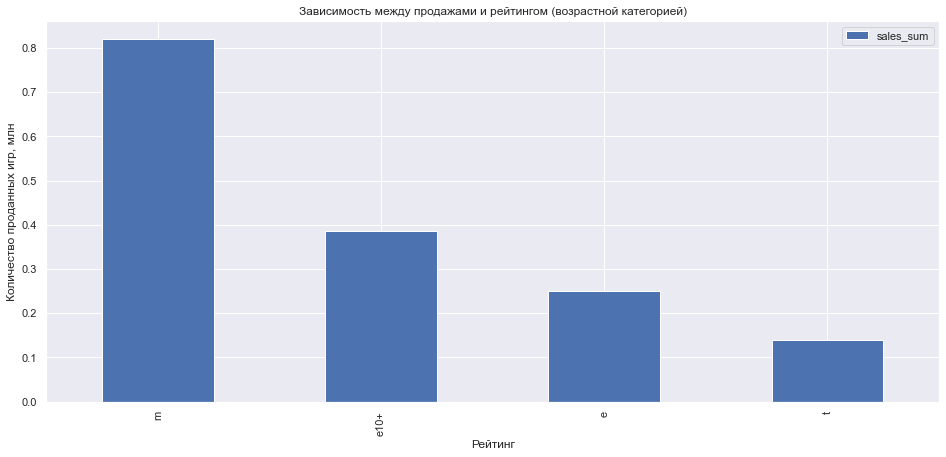

In [27]:
(sorted_sum_df.query('(platform == "ps4") & (rating != -77)').pivot_table(index='rating', values='sales_sum', aggfunc='median').sort_values(by='sales_sum', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Зависимость между продажами и рейтингом (возрастной категорией)')
plt.xlabel('Рейтинг')
plt.ylabel('Количество проданных игр, млн')

Больше всего продаются игры с рейтингом Mature(блокбастеры чаще всего именно с таким рейтингом), потом идут игры для всей семьи

In [28]:
df_new['user_score'] = df_new['user_score'].astype(float)
df_top = df_new.query('(critic_score > 0) & (user_score > 0)')

print('Корреляция продаж и отзывов критиков на игры PS4:', 
      (df_top.loc[df_top['platform'] == 'ps4']['critic_score']).corr(df_top.loc[df_top['platform'] == 'ps4']['sales_sum']))
print('Корреляция продаж и отзывов игроков на игры PS4:', 
      (df_top.loc[df_top['platform'] == 'ps4']['user_score']).corr(df_top.loc[df_top['platform'] == 'ps4']['sales_sum']))

Корреляция продаж и отзывов критиков на игры PS4: 0.4058948014583661
Корреляция продаж и отзывов игроков на игры PS4: -0.03362497596528883


Судя по результатам, отзывы критиков оказывают большее влияние на продажи, нежели от отзывов игроков, которые не оказывают его совсем. Тем не менее, коэффициент детерминации довольно низкий (меньше 50%), что говорит о слабой связи

### 3.5 Посмотрю на корреляцию между отзывами и продажами для актуальных консолей

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


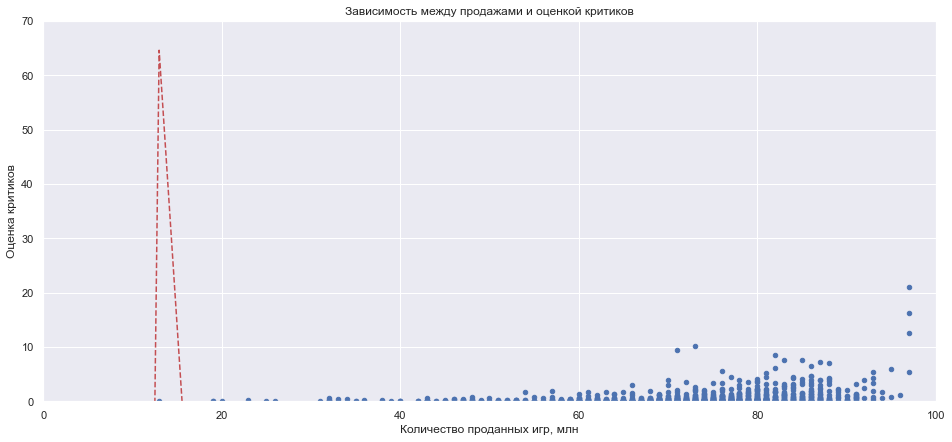

In [29]:
sorted_sum_df = df_new.sort_values('sales_sum')
sorted_sum_df.query('critic_score > 0').plot(x='critic_score', y='sales_sum', kind='scatter', title='Зависимость между продажами и оценкой критиков', xlim=(0,100), ylim=(0, 70), grid=True)

z = np.polyfit(sorted_sum_df['sales_sum'], sorted_sum_df['critic_score'], 2)
p = np.poly1d(z)
plt.plot(sorted_sum_df['critic_score'].sort_values(), p(sorted_sum_df['critic_score'].sort_values()) ,"r--")
plt.xlabel('Количество проданных игр, млн')
plt.ylabel('Оценка критиков')
plt.show()

Показатели смежные с лидерской консолью, выделяются только некоторые блокбастеры, видимо за авторством других платформ

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Количество проданных игр, млн')

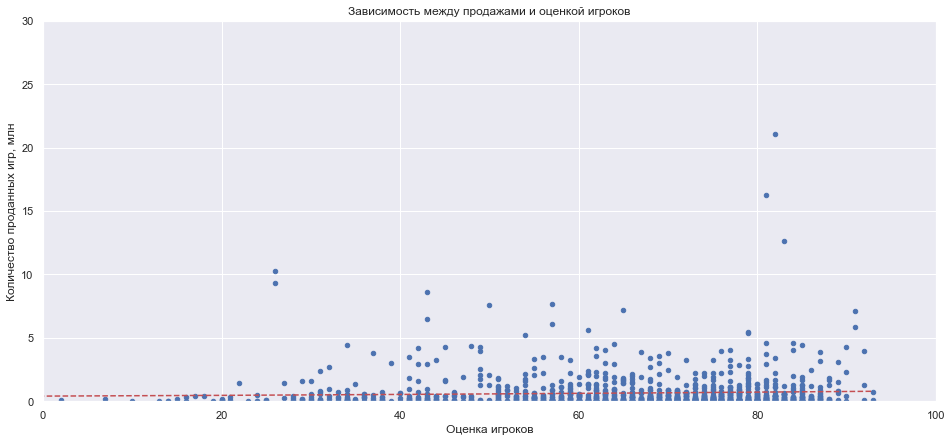

In [30]:
sorted_sum_df.query('(user_score != -77) & (user_score != -10)').plot(x='user_score', y='sales_sum', kind='scatter', title='Зависимость между продажами и оценкой игроков', xlim=(0, 100), ylim=(0, 30), grid=True)

z = np.polyfit(sorted_sum_df['user_score'], sorted_sum_df['sales_sum'], 2)
p = np.poly1d(z)
plt.plot(sorted_sum_df['user_score'].sort_values(), p(sorted_sum_df['user_score'].sort_values()) ,"r--")
plt.xlabel('Оценка игроков')
plt.ylabel('Количество проданных игр, млн')

Наблюдается аномальный скачок на рейтинге 2.5. Далее игры продаются равномерно и опять скачок в районе 9. Возможно это отдельные блокбастеры, которые выделяются на фоне остальных. В целом судя по всему оценка игроков не влияет на продажи игр

Text(0, 0.5, 'Количество проданных игр, млн')

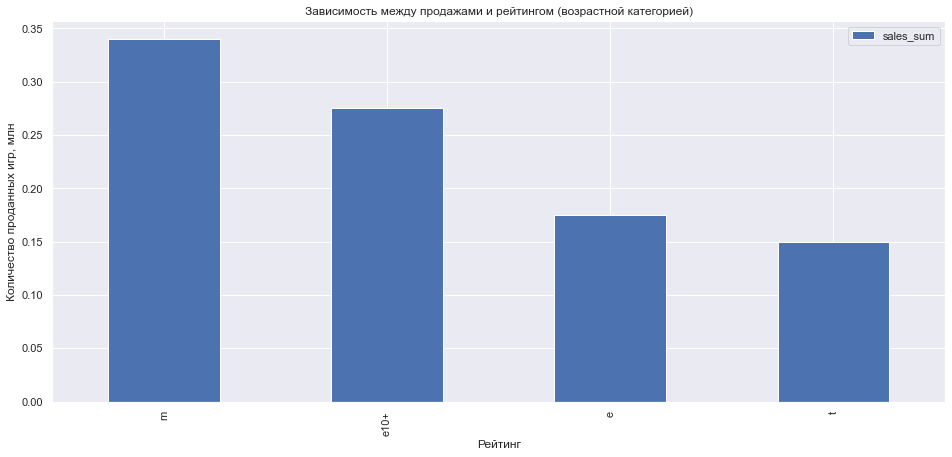

In [31]:
(sorted_sum_df.query('rating != -77').pivot_table(index='rating', values='sales_sum', aggfunc='median').sort_values(by='sales_sum', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Зависимость между продажами и рейтингом (возрастной категорией)')
plt.xlabel('Рейтинг')
plt.ylabel('Количество проданных игр, млн')

Больше всего игр продаётся с рейтингом М, далее Е10+, потом Е и Т. То есть как ни странно лучше всего продаются игры с рейтингом 17+, так называемые блокбастеры. Далее идет рейтинг - для всех от 10 - это семейные игры. Маркер -77 показывает, что игр с неопределенным возрастным ограничением совсем мало


Посчитаю корреляцию:

In [32]:
print('Корреляция продаж и отзывов критиков на игры PS3:', 
      (df_top.loc[df_top['platform'] == 'ps3']['critic_score']).corr(df_top.loc[df_top['platform'] == 'ps3']['sales_sum']))
print('Корреляция продаж и отзывов игроков на игры PS3:', 
      (df_top.loc[df_top['platform'] == 'ps3']['user_score']).corr(df_top.loc[df_top['platform'] == 'ps3']['sales_sum']))

print('Корреляция продаж и отзывов критиков на игры XBOXOne:', 
      (df_top.loc[df_top['platform'] == 'xone']['critic_score']).corr(df_top.loc[df_top['platform'] == 'xone']['sales_sum']))
print('Корреляция продаж и отзывов игроков на игры XBOXOne:', 
      (df_top.loc[df_top['platform'] == 'xone']['user_score']).corr(df_top.loc[df_top['platform'] == 'xone']['sales_sum']))

print('Корреляция продаж и отзывов критиков на игры 3DS:', 
      (df_top.loc[df_top['platform'] == '3ds']['critic_score']).corr(df_top.loc[df_top['platform'] == '3ds']['sales_sum']))
print('Корреляция продаж и отзывов игроков на игры 3DS:', 
      (df_top.loc[df_top['platform'] == '3ds']['user_score']).corr(df_top.loc[df_top['platform'] == '3ds']['sales_sum']))

print('Корреляция продаж и отзывов критиков на игры XBOX360:', 
      (df_top.loc[df_top['platform'] == 'x360']['critic_score']).corr(df_top.loc[df_top['platform'] == 'x360']['sales_sum']))
print('Корреляция продаж и отзывов игроков на игры XBOX360:', 
      (df_top.loc[df_top['platform'] == 'x360']['user_score']).corr(df_top.loc[df_top['platform'] == 'x360']['sales_sum']))

print('Корреляция продаж и отзывов критиков на игры WiiU:', 
      (df_top.loc[df_top['platform'] == 'wiiu']['critic_score']).corr(df_top.loc[df_top['platform'] == 'wiiu']['sales_sum']))
print('Корреляция продаж и отзывов игроков на игры WiiU:', 
      (df_top.loc[df_top['platform'] == 'wiiu']['user_score']).corr(df_top.loc[df_top['platform'] == 'wiiu']['sales_sum']))

print('Корреляция продаж и отзывов критиков на игры PC:', 
      (df_top.loc[df_top['platform'] == 'pc']['critic_score']).corr(df_top.loc[df_top['platform'] == 'pc']['sales_sum']))
print('Корреляция продаж и отзывов игроков на игры PC:', 
      (df_top.loc[df_top['platform'] == 'pc']['user_score']).corr(df_top.loc[df_top['platform'] == 'pc']['sales_sum']))

print('Корреляция продаж и отзывов критиков на игры PSVita:', 
      (df_top.loc[df_top['platform'] == 'psv']['critic_score']).corr(df_top.loc[df_top['platform'] == 'psv']['sales_sum']))
print('Корреляция продаж и отзывов игроков на игры PSVita:', 
      (df_top.loc[df_top['platform'] == 'psv']['user_score']).corr(df_top.loc[df_top['platform'] == 'psv']['sales_sum']))

print('Корреляция продаж и отзывов критиков на игры Wii:', 
      (df_top.loc[df_top['platform'] == 'wii']['critic_score']).corr(df_top.loc[df_top['platform'] == 'wii']['sales_sum']))
print('Корреляция продаж и отзывов игроков на игры Wii:', 
      (df_top.loc[df_top['platform'] == 'wii']['user_score']).corr(df_top.loc[df_top['platform'] == 'wii']['sales_sum']))

print('Корреляция продаж и отзывов критиков на игры PSP:', 
      (df_top.loc[df_top['platform'] == 'psp']['critic_score']).corr(df_top.loc[df_top['platform'] == 'psp']['sales_sum']))
print('Корреляция продаж и отзывов игроков на игры PSP:', 
      (df_top.loc[df_top['platform'] == 'psp']['user_score']).corr(df_top.loc[df_top['platform'] == 'psp']['sales_sum']))

print('Корреляция продаж и отзывов критиков на игры DS:', 
      (df_top.loc[df_top['platform'] == 'DS']['critic_score']).corr(df_top.loc[df_top['platform'] == 'ds']['sales_sum']))
print('Корреляция продаж и отзывов игроков на игры DS:', 
      (df_top.loc[df_top['platform'] == 'DS']['user_score']).corr(df_top.loc[df_top['platform'] == 'ds']['sales_sum']))


Корреляция продаж и отзывов критиков на игры PS3: 0.33380663565061736
Корреляция продаж и отзывов игроков на игры PS3: 0.02269094327112421
Корреляция продаж и отзывов критиков на игры XBOXOne: 0.4104220356129637
Корреляция продаж и отзывов игроков на игры XBOXOne: -0.09400318326920858
Корреляция продаж и отзывов критиков на игры 3DS: 0.33923492878531475
Корреляция продаж и отзывов игроков на игры 3DS: 0.2729904366942444
Корреляция продаж и отзывов критиков на игры XBOX360: 0.3503445460228666
Корреляция продаж и отзывов игроков на игры XBOX360: -0.0062381795323062416
Корреляция продаж и отзывов критиков на игры WiiU: 0.3795044989978414
Корреляция продаж и отзывов игроков на игры WiiU: 0.4086917438492651
Корреляция продаж и отзывов критиков на игры PC: 0.19412407903472956
Корреляция продаж и отзывов игроков на игры PC: -0.10923502736171778
Корреляция продаж и отзывов критиков на игры PSVita: 0.25409970218640765
Корреляция продаж и отзывов игроков на игры PSVita: 0.26547827205094254
Корре

 При смене поколений, отзывы критиков стали больше влиять на продажи игр - коэффициент корреляции между PS4 и PS3 отличается на 0.07. При этом консоли от майкрософт и сони имеют примерно одинаковую корреляцию с оценкой критиков. 
 
 А вот отзывы игроков много где (XboxOne, Xbox360, PC) имеют корреляцию либо близкую к нулю, либо немного отрицательную. Это говорит о том, что покупатели игр данных консолей не смотрят на оценки других игроков, но читают прессу, перед выбором новой игры. При 
этом пользователей PC мало интересуют и оценки критиков тоже
 
 Из интересного - пользователи некоторых консолей (PSVita, 3DS, WiiU) - одинакого наблюдают за оценками как критиков так и игроков, перед покупкой игр.

### 3.6 Анализ продаж по жанрам

Text(0, 0.5, 'Количество проданных игр, млн')

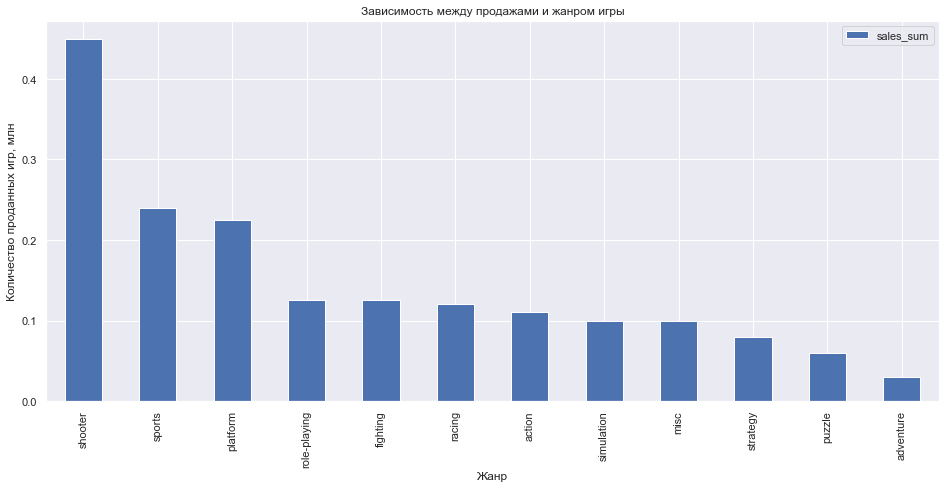

In [33]:
(sorted_sum_df.pivot_table(index='genre', values='sales_sum', aggfunc='median').sort_values(by='sales_sum', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Зависимость между продажами и жанром игры')
plt.xlabel('Жанр')
plt.ylabel('Количество проданных игр, млн')

Лучше всего продаются шутеры(простые стрелялки), они часто относятся к блокбастерам, далее идет жанр спорт, так популярный среди не больших любителей видеоигр, но с большим удовольствием играющих в футбол в компании друзей. Далее идет жанр платформеров - игры данного жанра часто бывают семейными

## 4. Портрет пользователей по регионам

### 4.1 Самые популярные консоли

In [34]:
df_new.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum').sort_values(by = 'na_sales', ascending=False)

,na_sales
platform,
ps4,108.74
xone,93.12
x360,81.66
ps3,63.50
3ds,38.20
wiiu,29.21
pc,11.11
wii,6.56
psv,5.04


Самыми популярными платформами Северной Америки являются: PS4, XboxOne, Xbox360, PS3  и 3DS  

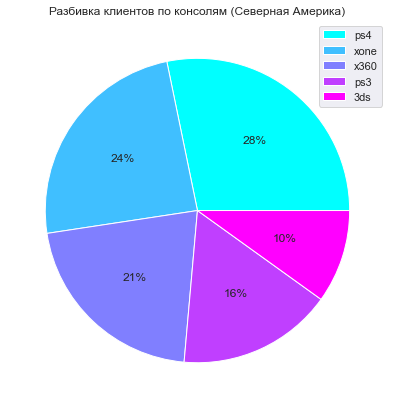

In [35]:
na_filtered = ['ps4', 'xone', 'x360', 'ps3', '3ds'] # создаю список с топовыми платформами региона
 
na_top = df_new.query('platform in @na_filtered')

(na_top.groupby('platform')['na_sales'].agg('sum').sort_values(ascending=False)
 .plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, 
       title='Разбивка клиентов по консолям (Северная Америка)', cmap='cool'))
plt.show()

In [36]:
df_new.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum').sort_values(by = 'jp_sales', ascending=False)

,jp_sales
platform,
3ds,67.81
ps3,23.35
psv,18.59
ps4,15.96
wiiu,10.88
psp,3.29
x360,0.51
xone,0.34
wii,0.05


Самыми популярными платформами Японии являются: 3DS, PS3, PSVita, PS4  и WiiU. Все-таки там больше ценят портативные устройства, нежели домашние  

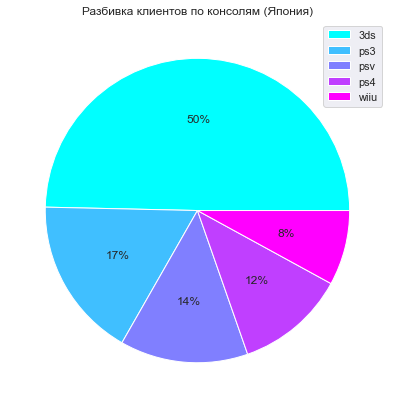

In [37]:
jp_filtered = ['3ds', 'ps3', 'psv', 'ps4', 'wiiu'] # создаю список с топовыми платформами региона
 
jp_top = df_new.query('platform in @jp_filtered')

(jp_top.groupby('platform')['jp_sales'].agg('sum').sort_values(ascending=False)
 .plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, 
       title='Разбивка клиентов по консолям (Япония)', cmap='cool'))
plt.show()

In [38]:
df_new.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum').sort_values(by = 'eu_sales', ascending=False)

,eu_sales
platform,
ps4,141.09
ps3,67.81
xone,51.59
x360,42.52
3ds,30.96
pc,25.36
wiiu,19.85
psv,6.10
wii,5.93


Самыми популярными платформами  Европы являются: PS4, PS3, XboxOne, Xbox360  и 3DS  

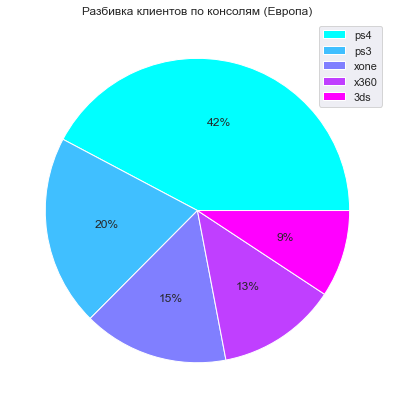

In [39]:
eu_filtered = ['ps4', 'ps3', 'xone', 'x360', '3ds'] # создаю список с топовыми платформами региона
 
eu_top = df_new.query('platform in @eu_filtered')

(eu_top.groupby('platform')['eu_sales'].agg('sum').sort_values(ascending=False)
 .plot(kind='pie', labels=None, label='', autopct='%1.0f%%', legend=True, 
       title='Разбивка клиентов по консолям (Европа)', cmap='cool'))
plt.show()

### 4. 2 Самые популярные жанры

Text(0, 0.5, 'Количество проданных игр, млн')

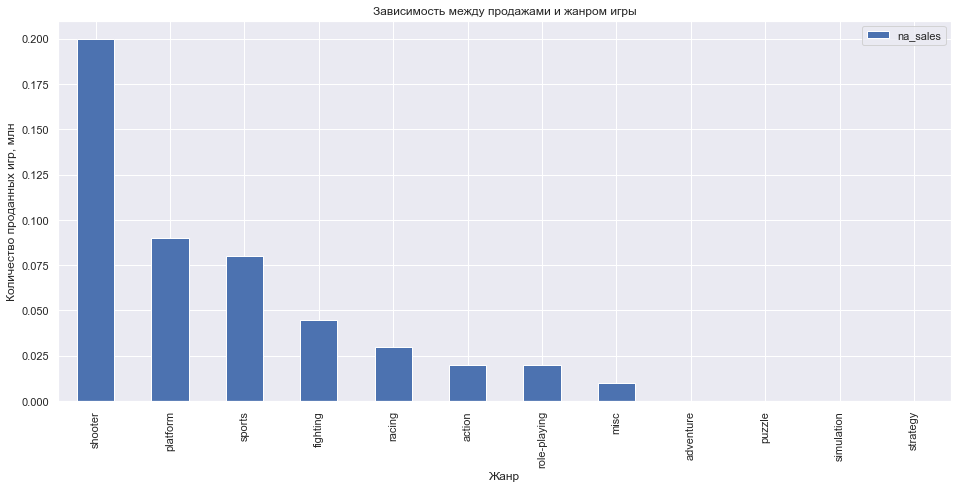

In [40]:
(sorted_sum_df.pivot_table(index='genre', values='na_sales', aggfunc='median').sort_values(by='na_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Зависимость между продажами и жанром игры')
plt.xlabel('Жанр')
plt.ylabel('Количество проданных игр, млн')

In [41]:
na_genre_filtered = ['shooter', 'platform', 'sports', 'fighting', 'racing'] # создаю список с топовыми жанрами
 
sorted_sum_df.query('genre in @na_genre_filtered').pivot_table(index='year_of_release',columns='genre',values='na_sales',aggfunc='sum')

genre,fighting,platform,racing,shooter,sports
year_of_release,,,,,
2013,3.12,11.35,4.22,30.72,19.14
2014,6.89,3.01,5.92,30.84,19.82
2015,3.70,2.49,2.09,31.94,18.77
2016,1.84,1.29,0.73,16.24,7.54


Text(0, 0.5, 'Количество проданных игр, млн')

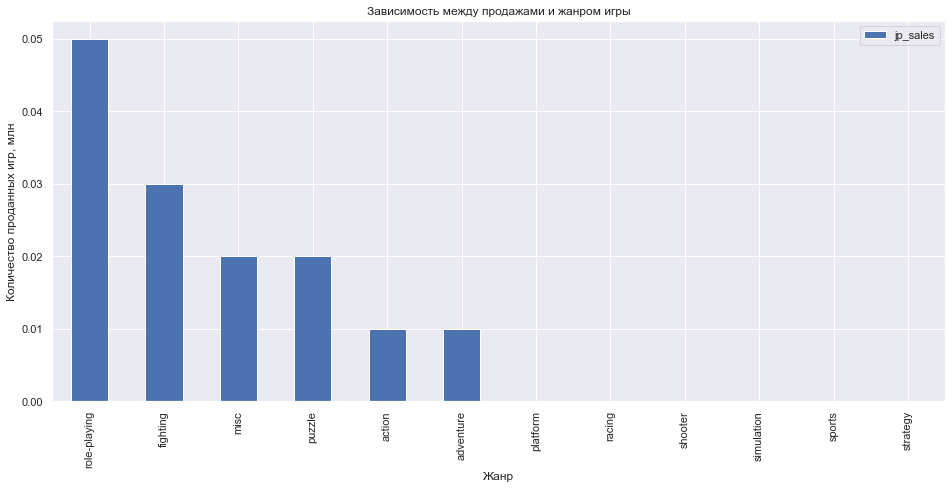

In [42]:
(sorted_sum_df.pivot_table(index='genre', values='jp_sales', aggfunc='median').sort_values(by='jp_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Зависимость между продажами и жанром игры')
plt.xlabel('Жанр')
plt.ylabel('Количество проданных игр, млн')

In [43]:
jp_genre_filtered = ['role-playing', 'fighting', 'misc', 'puzzle', 'action'] # создаю список с топовыми жанрами
 
sorted_sum_df.query('genre in @jp_genre_filtered').pivot_table(index='year_of_release',columns='genre',values='jp_sales',aggfunc='sum')

genre,action,fighting,misc,puzzle,role-playing
year_of_release,,,,,
2013,10.91,1.28,3.59,0.25,19.88
2014,6.53,4.83,2.42,0.41,17.75
2015,15.98,0.79,2.15,0.52,6.80
2016,7.07,0.75,1.04,0.00,6.61


Text(0, 0.5, 'Количество проданных игр, млн')

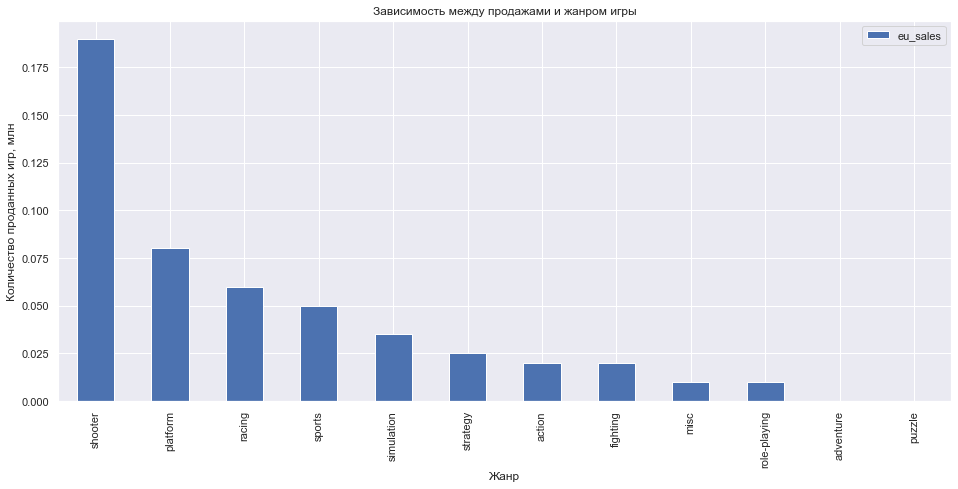

In [44]:
(sorted_sum_df.pivot_table(index='genre', values='eu_sales', aggfunc='median').sort_values(by='eu_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Зависимость между продажами и жанром игры')
plt.xlabel('Жанр')
plt.ylabel('Количество проданных игр, млн')

In [45]:
eu_genre_filtered = ['shooter', 'platform', 'racing', 'sports', 'simulation'] # создаю список с топовыми жанрами
 
sorted_sum_df.query('genre in @eu_genre_filtered').pivot_table(index='year_of_release',columns='genre',values='na_sales',aggfunc='sum')

genre,platform,racing,shooter,simulation,sports
year_of_release,,,,,
2013,11.35,4.22,30.72,2.23,19.14
2014,3.01,5.92,30.84,1.27,19.82
2015,2.49,2.09,31.94,1.20,18.77
2016,1.29,0.73,16.24,0.16,7.54


 В Европе и штатах одинаковые предпочтения по жанрам - это шутеры и платформеры, тогда как в Японии отдают предпочтение между гонками и шутерами, а также файтингами, которые так популярны благодаря популярности игровых автоматов

### 4.3 Влияние возрастных ограничений

Text(0, 0.5, 'Количество проданных игр, млн')

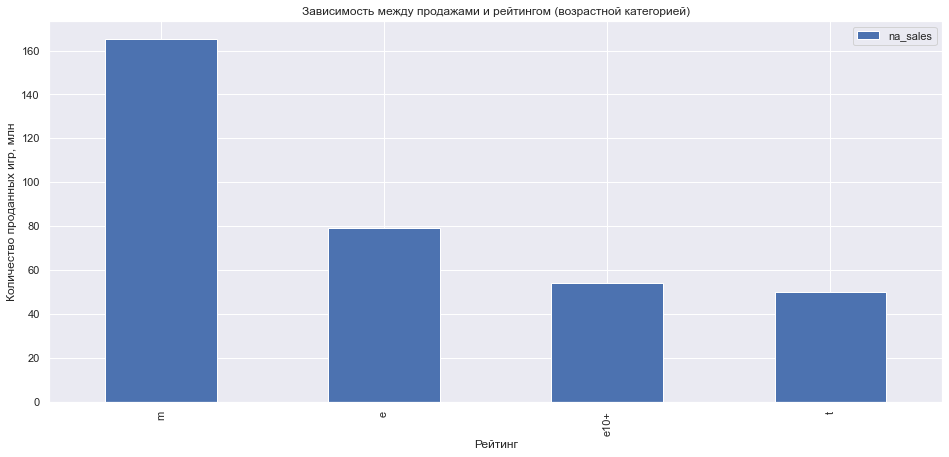

In [46]:
(sorted_sum_df.query('rating != -77').pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Зависимость между продажами и рейтингом (возрастной категорией)')
plt.xlabel('Рейтинг')
plt.ylabel('Количество проданных игр, млн')

Text(0, 0.5, 'Количество проданных игр, млн')

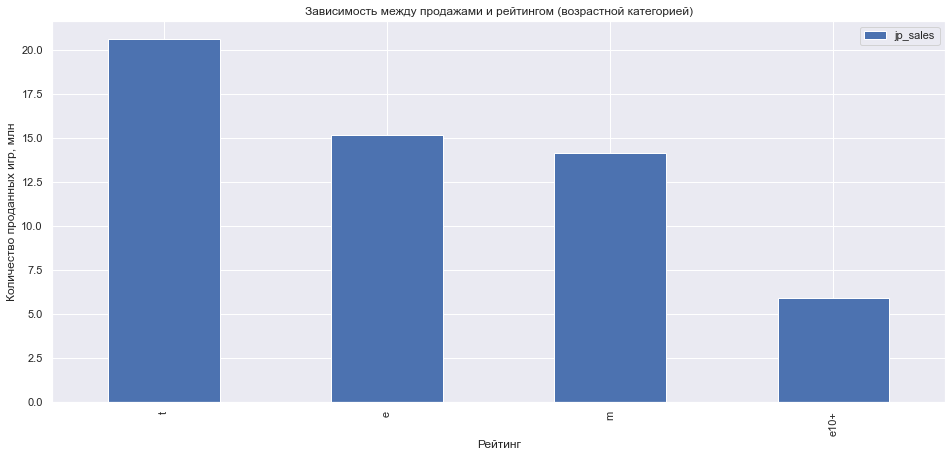

In [47]:
(sorted_sum_df.query('rating != -77').pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Зависимость между продажами и рейтингом (возрастной категорией)')
plt.xlabel('Рейтинг')
plt.ylabel('Количество проданных игр, млн')

Text(0, 0.5, 'Количество проданных игр, млн')

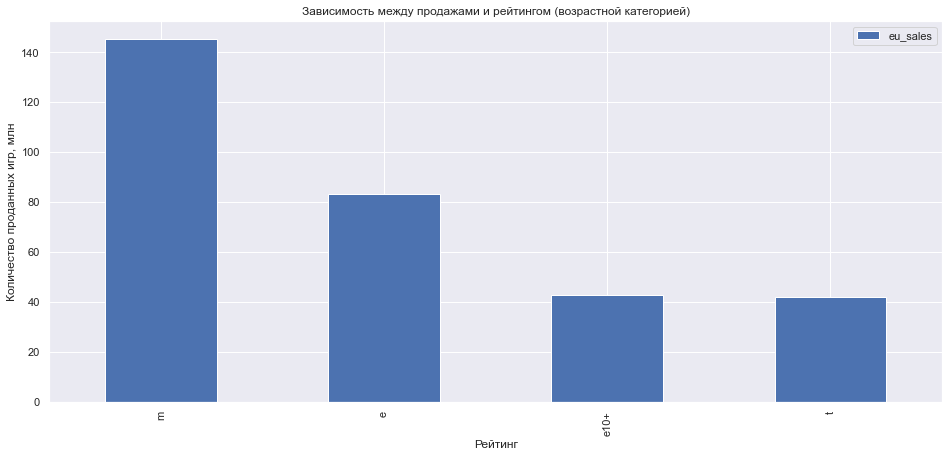

In [48]:
(sorted_sum_df.query('rating != -77').pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
    .plot(kind = 'bar', grid=True))
plt.title('Зависимость между продажами и рейтингом (возрастной категорией)')
plt.xlabel('Рейтинг')
plt.ylabel('Количество проданных игр, млн')

In [49]:
sorted_sum_df.query('rating != -77').pivot_table(index='rating', values=['eu_sales', 'jp_sales', 'na_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales
rating,,,
e,83.36,15.14,79.05
e10+,42.69,5.89,54.24
m,145.32,14.11,165.21
t,41.95,20.59,49.79


Опять же, в Европе и штатах больше всего играют в игры с рейтингом для взрослых, а также семейные 10+, тогда как в Японии больше ценятся игры для подростков 13+

## 5. Проверка гипотез

Сначала проверю гипотезу о том, что средние пользовательские рейтинги платформ XboxOne и PC одинаковые

Н0: средние пользовательские рейтинги XboxOne равняются средним пользовательским рейтингам PC

Н1: средние пользовательские рейтинги XboxOne не равняются средним пользовательским рейтингам PC

In [50]:
xone_user_rate = df_new.query('platform == "xone" and user_score > 0')['user_score']
pc_user_rate = df_new.query('platform == "pc" and user_score > 0')['user_score']

print('Средний рейтинг XboxOne : ', xone_user_rate.mean())
print('Средний рейтинг PC : ', pc_user_rate.mean())

alpha = 0.05 #беру пятипроцентный уровень значимости

results = st.ttest_ind(xone_user_rate, pc_user_rate, equal_var = True) 

print('p-значение:', results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний рейтинг XboxOne :  65.21428571428571
Средний рейтинг PC :  62.696774193548386
p-значение: 0.14012658403611722
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза о равенстве рейтингов с пользователей XboxOne и PC подтверджается на пяти-процентном уровне. 

Или другими словами: средние значения рейтинга от пользователей XboxOne и PC равны с вероятность 95%.

Далее проверю гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные.

Н0: средние пользовательские рейтинги жанра Action равняются средним пользовательским рейтингам жанра Sports

Н1: средние пользовательские рейтинги жанра Action не равняются средним пользовательским рейтингам жанра Sports

In [51]:
action_user_rate = df_new.query('genre == "action" and user_score > 0')['user_score']
sports_user_rate = df_new.query('genre == "sports" and user_score > 0')['user_score']

print('Средний рейтинг Action игр : ', action_user_rate.mean())
print('Средний рейтинг Sports игр : ', sports_user_rate.mean())

alpha = 0.05 #беру пятипроцентный уровень значимости

results = st.ttest_ind(action_user_rate, sports_user_rate, equal_var = True) 

print('p-значение:', results.pvalue) 

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний рейтинг Action игр :  68.37532133676092
Средний рейтинг Sports игр :  52.38125
p-значение: 1.0517832389140778e-27
Отвергаем нулевую гипотезу


Нулевая гипотеза о равенстве рейтингов с пользователей Action и Sports отвергается на пяти-процентном уровне. 

Или другими словами: средние значения рейтинга от пользователей Action и Sports не равны с вероятность 95%.

## 6. Вывод

- **Главные выводы:**
1) Наблюдая со стороны на историю игровых консолей, можно обратить внимание на их жизненные циклы, которые длятся около десятилетия. Закономерно консоли старого поколения сменяются новыми, все-таки пользователям важны вычислительные мощности - графика и возможности.
2) Можно сказать, что самыми популярными жанрами в игровой индустрии в целом являются шутеры и спортом, при этом Япония выделяется от всех остальных, там также очень любят файтинги, у нее портативные консоли в лидерах, наверное потому что в небольшой Японии, на каждого жителя приходится маленькое количество квадратных метров жилой площади, в связи с чем много человек дома для игры в приставку не собирается.
3) Удивительно, но на больших американо-европейских консолях люди почти не следят за пользовательскими рейтингами, при покупке новых игр, им куда важнее мнение профессиональной прессы.